In [1]:
import os
import pickle

from fastfusion.frontend.arch import Memory
from fastfusion.frontend.specification import Specification

import copy
import time
from fastfusion import Specification
from fastfusion.mapper import Metrics

from fastfusion.mapper.FFM import make_pmappings, join_pmappings, MultiEinsumPmappings
import fastfusion as ff
from typing import Callable

# TODO: Make a setting for the below two in the spec
# TODO: Generate pmappings one Einsum at a time. Once we've made compatibility, check it
# against the previously-generated compatibilities and stop if there's no match.
# TODO: Once the previous is done, also add a forward check. Once the compatibilities of
# a particular Einsum are generated, we can immediately check the previous Einsums.

objective = lambda df: df['Total<SEP>latency']# * df['Total_Energy']
LOAD_FROM_CACHE = True



# def get_filter_mappings_function(
#     parameterization: str,
# ) -> Callable[[ff.mapper.FFM.PmappingGroup], bool]:

#     all_tensors = {"I", "Q", "K", "V", "QK", "QK_softmax", "AV", "Z", "FFA"}
#     must_fuse = set()
#     must_not_fuse = set()

#     if parameterization == "Unfused":
#         must_not_fuse = all_tensors
#     elif parameterization == "FlashAttention A":
#         must_fuse = {"QK", "QK_softmax"}
#         must_not_fuse = all_tensors - must_fuse
#     elif parameterization == "FlashAttention B":
#         must_fuse = {"Q", "K", "QK", "QK_softmax"}
#         must_not_fuse = all_tensors - must_fuse
#     elif parameterization == "FFM":
#         pass
#     elif parameterization == "Fixed-Dataflow":
#         pass

#     def filter_mappings(
#         mappings: ff.mapper.FFM.PmappingGroup
#     ) -> bool:
#         fused_tensors = {t.name for t in mappings.compatibility.tensors if t.resource_name != "MainMemory"}
#         unfused_tensors = {t.name for t in mappings.compatibility.tensors if t.resource_name == "MainMemory"}

#         if must_not_fuse & fused_tensors:
#             return False
#         if must_fuse & unfused_tensors:
#             return False
#         return True

#     return filter_mappings


def get_fused_mappings(
        spec: Specification,
        cache_key=None,
        parameterization="",
    ) -> tuple[float, MultiEinsumPmappings]:
    os.makedirs("cache", exist_ok=True)
    if cache_key is not None:
        fname = parameterization + "-".join(str(x) for x in cache_key)
        if LOAD_FROM_CACHE and os.path.exists(f"cache/{fname}.pkl"):
            print(f"Loading from cache: {fname}")
            mappings = pickle.load(open(f"cache/{fname}.pkl", "rb"))
            if mappings is not None:
                return objective(mappings.data).min() if mappings is not None else None, mappings
    spec = copy.deepcopy(spec)

    main_memory: Memory = spec.arch.nodes["MainMemory"]

    filter_mappings = lambda x: True
    if parameterization == "Unfused":
        main_memory.constraints.tensors.keep = "All"
    elif parameterization == "FlashAttention B":
        main_memory.constraints.tensors.keep = "All - (I | Q | K | V | QK | QK_softmax)"
    elif parameterization == "FlashAttention A":
        main_memory.constraints.tensors.keep = "All - (QK | QK_softmax)"#Q | K | V | I"# | QK | FFA"
    elif parameterization == "FFM":
        main_memory.constraints.tensors.keep = "~Intermediates" #"# | AV | Z "
        main_memory.constraints.tensors.may_keep = "All" #"# | AV | Z "
    elif parameterization == "Fixed-Dataflow":
        main_memory.constraints.tensors.keep = "~Intermediates | weight"
        main_memory.constraints.tensors.may_keep = "All"
        # spec.arch.nodes["GlobalBuffer"].constraints.dataflow.tensor_order_options = [
        #     ["MainMemory.tensors & weight",
        #      "MainMemory.tensors & input",
        #      "MainMemory.tensors & output",
        #      "weight - MainMemory.tensors",
        #      "input - MainMemory.tensors",
        #      "output - MainMemory.tensors"],
        # ]

    # if parameterization in [
    #     "Unfused",
    #     "FlashAttention B",
    #     "FlashAttention A",
    #     "FFM",
    #     "Unfused"
    # ]:
    #     pass
    # elif parameterization == "Fixed-Dataflow":
    #     main_memory.constraints.tensors.keep = "~Intermediates | weight"
    #     main_memory.constraints.tensors.may_keep = "All"
    #     spec.arch.nodes["GlobalBuffer"].constraints.dataflow.tensor_order_options = [
    #         ["MainMemory.tensors & weight",
    #          "MainMemory.tensors & input",
    #          "MainMemory.tensors & output",
    #          "weight - MainMemory.tensors",
    #          "input - MainMemory.tensors",
    #          "output - MainMemory.tensors"],
    #     ]
    else:
        assert False, f"Parameterization {parameterization} not supported"

    if LOAD_FROM_CACHE and cache_key is not None and os.path.exists(f"pmappings_cache/{fname}.pkl"):
        print(f"Loading from cache: {fname}")
        pmappings = pickle.load(open(f"cache/pmappings_{fname}.pkl", "rb"))
    else:
        pmappings = make_pmappings(spec, cache_dir="/tmp/cache_ffm")
        pickle.dump(pmappings, open(f"cache/pmappings_{fname}.pkl", "wb"))
    try:
        pmappings = pmappings._filter(filter_mappings)
        mappings = join_pmappings(spec, pmappings)
    except:
        mappings = None

    # TODO: the final joined pmappings have lambdas somewhere, which can't be pickled.
    if cache_key is not None:
        pickle.dump(mappings, open(f"cache/{fname}.pkl", "wb"))

    return objective(mappings.data).min() if mappings is not None else None, mappings

parameterization2edp = {}
parameterization2mappings = {}


# ================== Exploration Parameters ====================================
MAPSPACES = ["Unfused", "FlashAttention A", "FlashAttention B", "Fixed-Dataflow", "FFM"]
# MAPSPACES = ["Fixed-Dataflow", "FFM"]

# Tuple of (batch_size, n_tokens)
WORKLOAD_SHAPES = [(64, 512), (1, 8192), (1, 32768)]

# Number of cores in the TPU-like architecture
N_CORES = [256]


for batch_size, n_tokens in WORKLOAD_SHAPES:
        for n_cores in N_CORES:
            for a in [0]:
                spec = Specification.from_yaml(
                    f"../../examples/arches/tpu_v4i_like.arch.yaml",
                    f"../../examples/workloads/gpt3_6.7B.workload.yaml",
                    jinja_parse_data={
                        "BATCH_SIZE": batch_size,
                        "N_TOKENS": n_tokens,
                    }
                )
                if a:
                    spec.arch.nodes["LocalBuffer"].constraints.spatial["Z"].must_reuse = "weight"
                spec.mapper.ffm.metrics = Metrics.LATENCY
                cache_key = (batch_size, n_tokens, n_cores, a) if a else (batch_size, n_tokens, n_cores)
                spec.arch.nodes["LocalBuffer"].spatial["Z"].fanout = n_cores
                for parameterization in MAPSPACES:
                    x, mappings = get_fused_mappings(
                        spec,
                        cache_key=cache_key,
                        parameterization=parameterization,
                    )
                    parameterization2edp.setdefault((batch_size, n_tokens, n_cores), {})[parameterization] = x
                    parameterization2mappings.setdefault((batch_size, n_tokens, n_cores), {})[parameterization] = mappings

WARNING Loading configuration file from /home/tanner/.config/fastfusion/config.yaml


Loading from cache: Unfused64-512-256
Loading from cache: FlashAttention A64-512-256
Loading from cache: FlashAttention B64-512-256
Loading from cache: Fixed-Dataflow64-512-256
Loading from cache: FFM64-512-256


WARNING Loading configuration file from /home/tanner/.config/fastfusion/config.yaml


Loading from cache: Unfused1-8192-256
Loading from cache: FlashAttention A1-8192-256
Loading from cache: FlashAttention B1-8192-256
Loading from cache: Fixed-Dataflow1-8192-256
Loading from cache: FFM1-8192-256


WARNING Loading configuration file from /home/tanner/.config/fastfusion/config.yaml


Loading from cache: Unfused1-32768-256
Loading from cache: FlashAttention A1-32768-256
Loading from cache: FlashAttention B1-32768-256
Loading from cache: Fixed-Dataflow1-32768-256
Loading from cache: FFM1-32768-256


Elementwise-Only: {'Batch=64\nTokens=512': np.float32(0.4359492), 'Batch=1\nTokens=8k': np.float32(0.4848659), 'Batch=1\nTokens=32k': np.float32(0.504521)}
FlashAttention A: {'Batch=64\nTokens=512': np.float32(0.518687), 'Batch=1\nTokens=8k': np.float32(0.88265914), 'Batch=1\nTokens=32k': np.float32(0.9821747)}
FlashAttention B: {'Batch=64\nTokens=512': np.float32(0.5981651), 'Batch=1\nTokens=8k': np.float32(0.9282484), 'Batch=1\nTokens=32k': np.float32(0.98643106)}
Fixed-Dataflow: {'Batch=64\nTokens=512': np.float32(0.92429113), 'Batch=1\nTokens=8k': np.float32(0.97966915), 'Batch=1\nTokens=32k': np.float32(1.0)}
Fast & Fusiest: {'Batch=64\nTokens=512': np.float32(1.0), 'Batch=1\nTokens=8k': np.float32(1.0), 'Batch=1\nTokens=32k': np.float32(1.0)}


ImportError: cannot import name 'etree' from 'lxml' (/usr/lib/python3/dist-packages/lxml/__init__.py)

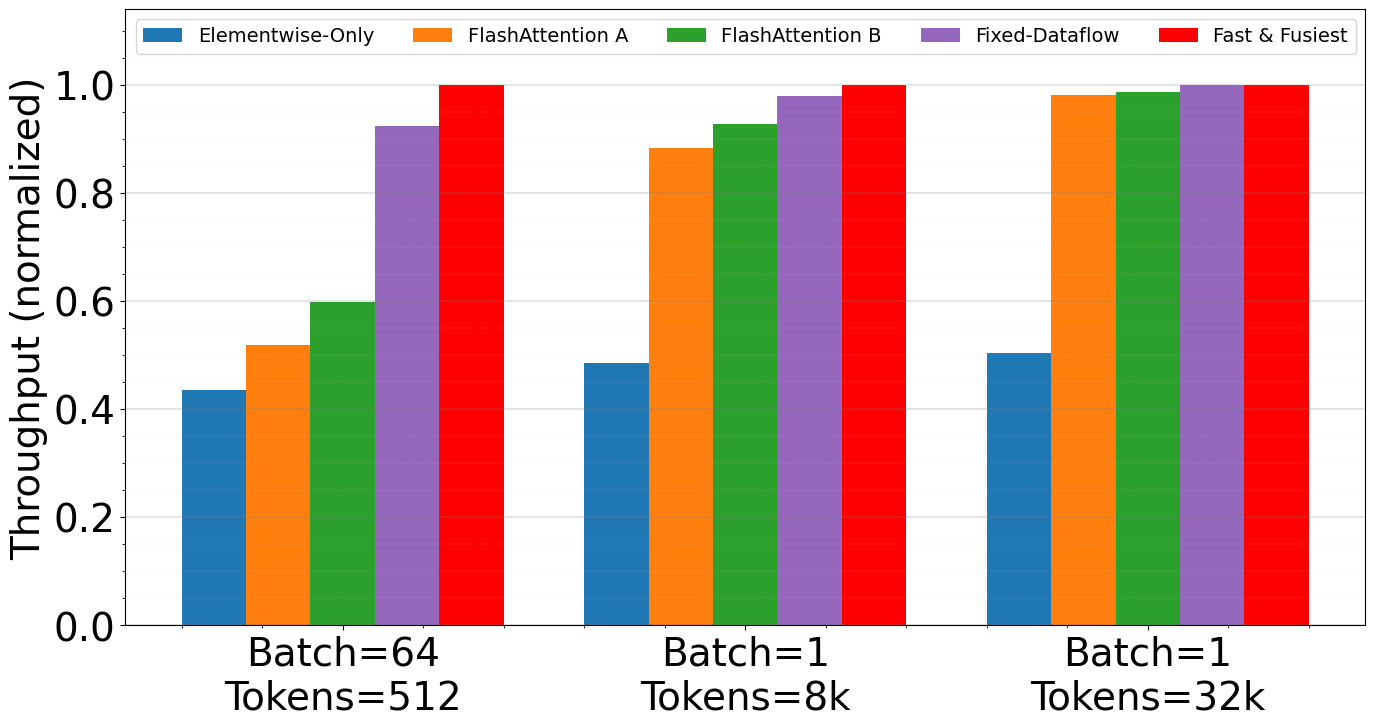

In [2]:
results = parameterization2edp

import matplotlib.pyplot as plt
plt.style.use('default')
plt.rcParams.update({'font.size': 28})

def plot_default_formatting(ax, grid_axis='both'):
    ax.tick_params(axis='both', which='major')#, labelsize=20)
    ax.tick_params(axis='both', which='minor')#, labelsize=20)
    legend = ax.legend()
    legend.get_frame().set_facecolor('white')
    legend.get_frame().set_edgecolor('black')
    # Set legend ncols to 5
    for spine in ax.spines.values():
        spine.set_edgecolor('black')
    ax.legend(fontsize=14, ncols=5)
    ax.minorticks_on()
    ax.grid(axis=grid_axis, which='major', linestyle='-', linewidth='0.3', color='gray')
    ax.grid(axis=grid_axis, which='minor', linestyle='--', linewidth='0.1', color='lightgray')

colors = [
    "#1f77b4",
    "#ff7f0e",
    "#2ca02c",
    "#9467bd",
    "#ff0000",
]

def make_bar_chart(
    data,
    title,
    xlabel,
    ylabel,
    y_scale,
    output_file=None,
    normalize: bool = False,
    ylim=(None, None),
    xlim=(None, None),
):
    """
    Create a bar chart from the given data and save it as a PDF.
    """
    plt.figure(figsize=(16, 8))

    if isinstance(data, dict) and isinstance(next(iter(data.values())), dict):
        bar_width = 0.8 / len(data)
        keys = list(next(iter(data.values())).keys())
        x = range(len(keys))
        first = next(iter(data.values()))

        for i, (label, values) in enumerate(data.items()):
            bar_positions = [pos + i * bar_width for pos in x]
            to_plot = values
            if normalize:
                to_plot = {k: v / first[k] for k, v in values.items()}
            bars = plt.bar(bar_positions, to_plot.values(), width=bar_width, label=label, color=colors[i])
        plt.xticks([pos + (len(data) - 1) * bar_width / 2 for pos in x], keys)
        # plt.legend(loc='upper right', fontsize=10)
        plt.legend(fontsize=10, ncol=len(data), loc='upper center')
    else:
        keys = list(data.keys())
        bars = plt.bar(keys, data.values())


    # Set logarithmic scale for Y-axis if specified
    if y_scale == 'log':
        plt.yscale('log')

    # Add labels and title
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.ylim(ylim)
    plt.xlim(xlim)

    # Rotate X-axis labels vertically
    # plt.xticks(rotation=90)

    plot_default_formatting(plt.gca(), grid_axis='y')

    if output_file is not None:
        with open(output_file, 'wb') as f:
            plt.savefig(f, format='pdf', bbox_inches='tight')

    # Show the plot
    plt.show()

entries = {}

name_changes = {
    "Unfused": "Elementwise-Only",
    "FlashAttention A": "FlashAttention A",
    "FlashAttention B": "FlashAttention B",
    "FFM": "Fast & Fusiest",
    # (64, 512, 64): "Big Batch\n64 Cores",
    (64, 512, 256): "Batch=64\nTokens=512",#\n256 Cores",
    # (1, 16384, 64): "Big Seq\n64 Cores",
    (1, 8192, 256): "Batch=1\nTokens=8k",#\n256 Cores",
    # (1, 32768, 256): "Bigger Seq\n256 Cores",
    (1, 32768, 256): "Batch=1\nTokens=32k",#\n256 Cores",
}

for k, v in results.items():
    if k not in name_changes:
        continue
    k = name_changes.get(k, k)
    entries[k] = {name_changes.get(k2, k2): 1/v[k2] if v[k2] else 0 for k2 in v}
    max_val = max(entries[k].values())
    for k2, v2 in entries[k].items():
        entries[k][k2] = v2 / max_val if max_val else 0

entries={k: v for k, v in sorted(entries.items(), key=lambda x: list(name_changes.values()).index(x[0]))}

# Transpose everything
entries2 = {}
for k, v in entries.items():
    for k2, v2 in v.items():
        entries2.setdefault(k2, {})[k] = v2
entries = entries2

# Print as a table
for name, e in entries2.items():
    print(f"{name}: {e}")

make_bar_chart(entries, title=None, xlabel=None, ylabel="Throughput (normalized)", y_scale='linear', output_file="mapsapce_compare.pdf", normalize=False, ylim=(0, 1.14), xlim=(None, None))

In [6]:
# mapping_ffm = next(iter(parameterization2mappings.values()))["FFM"][1]
# from IPython.display import SVG
# display(mapping_ffm.render())
for k, v in parameterization2mappings.items():
    print(k)
    for k2, v2 in v.items():
        print(f"\t{k2}: {v2}")

k = (64, 512, 256)
k2s = ["Unfused", "FlashAttention A", "FlashAttention B", "FFM", "Fixed-Dataflow"]
for k2 in k2s:
    mappings = parameterization2mappings[k][k2]
    min_latency_index = mappings.data["Total<SEP>latency"].idxmin()
    print(f'{k2}')
    display(mappings[min_latency_index].render())

(64, 512, 256)
	Unfused: <fastfusion.mapper.FFM.mappings.Mappings object at 0x7f3854d806e0>
	FlashAttention A: <fastfusion.mapper.FFM.mappings.Mappings object at 0x7f384b6055b0>
	FlashAttention B: <fastfusion.mapper.FFM.mappings.Mappings object at 0x7f384b81f6e0>
	Fixed-Dataflow: <fastfusion.mapper.FFM.mappings.Mappings object at 0x7f384a38ade0>
	FFM: <fastfusion.mapper.FFM.mappings.Mappings object at 0x7f384b382a80>
(1, 8192, 256)
	Unfused: <fastfusion.mapper.FFM.mappings.Mappings object at 0x7f384b382d50>
	FlashAttention A: <fastfusion.mapper.FFM.mappings.Mappings object at 0x7f38469e4ad0>
	FlashAttention B: <fastfusion.mapper.FFM.mappings.Mappings object at 0x7f38470b42f0>
	Fixed-Dataflow: <fastfusion.mapper.FFM.mappings.Mappings object at 0x7f3854dfd070>
	FFM: <fastfusion.mapper.FFM.mappings.Mappings object at 0x7f3844b6f5c0>
(1, 32768, 256)
	Unfused: <fastfusion.mapper.FFM.mappings.Mappings object at 0x7f3848a13260>
	FlashAttention A: <fastfusion.mapper.FFM.mappings.Mappings objec

FlashAttention A


FlashAttention B


FFM
Warning. Matching loops for {'p'} in [0..4) stride=128 and for m in [0..4) stride=128. Need rank variable translation here.
Warning. Matching loops for {'p'} in [0..2) stride=256 and for m in [0..2) stride=256. Need rank variable translation here.


Fixed-Dataflow


In [5]:
k = (64, 512, 256)
x = "FFM"
mappings = parameterization2mappings[k][x]
min_latency_index = mappings.data["Total<SEP>latency"].idxmin()
for k, v in mappings[min_latency_index].access("latency").to_dict().items():
    print(f"{k}: {v}")

Total: 0.004480641335248947
I<SEP>GlobalBuffer: 0
I<SEP>MainMemory: 0.000218595648208469
I<SEP>ScalarUnit: 3.900952378899092e-06
V<SEP>MAC: 0.00012483047612477094
V<SEP>Register: 0
V<SEP>LocalBuffer: 0
V<SEP>GlobalBuffer: 0
V<SEP>MainMemory: 0.00032789347460493445
K<SEP>MAC: 0.00012483047612477094
K<SEP>Register: 0
K<SEP>LocalBuffer: 0
K<SEP>GlobalBuffer: 0
K<SEP>MainMemory: 0.00010929782729363069
Q<SEP>MAC: 0.00012483047612477094
Q<SEP>Register: 0
Q<SEP>LocalBuffer: 0
Q<SEP>GlobalBuffer: 0
Q<SEP>MainMemory: 0.00010929782729363069
QK<SEP>MAC: 1.5603809515596367e-05
QK<SEP>Register: 0
QK<SEP>LocalBuffer: 0
QK<SEP>GlobalBuffer: 0
QK<SEP>MainMemory: 0.0008743826183490455
QK_softmax<SEP>ScalarUnit: 1.5603809515596367e-05
QK_softmax<SEP>LocalBuffer: 0
QK_softmax<SEP>GlobalBuffer: 0
QK_softmax<SEP>MainMemory: 0.000874382592833876
AV<SEP>MAC: 1.5603809515596367e-05
AV<SEP>Register: 0
AV<SEP>LocalBuffer: 0
AV<SEP>GlobalBuffer: 0
AV<SEP>MainMemory: 0.00021859565458726138
Z<SEP>MAC: 0.0001248304